# Lee et al. Multilayer Perceptron
In this notebook, I provide an implementation of the multilayer perceptron (MLP) proposed by Lee et al. (Lee et al., 2022) in a federated enviroment. Note the proposed MLP is altered for for the purpose of binary sequence-to-label classification; corresponding comments detail all adjustments. The spectra data are first obtained from all files in the "dataset" folder.

In [1]:
# Dependencies
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
import flwr as fl
from collections import OrderedDict
from typing import List, Tuple, Dict
from sklearn.metrics import confusion_matrix
from typing import Optional
import os
import logging

# Set logging level to critical to reduce output noise
logging.getLogger("flwr").setLevel(logging.CRITICAL)

# Define device for computation (GPU if available, else CPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLIENTS = 5  # Number of federated clients

In [2]:
# Load and preprocess data
def load_and_preprocess(train_file, val_file):
    """
    Load and preprocess the data from CSV files.

    Parameters:
        train_file (str): Path to the training CSV file.
        val_file (str): Path to the validation CSV file.

    Returns:
        Tuple containing training samples, training labels, validation samples, and validation labels.
    """
    # Read the data from CSV files
    train_df = pd.read_csv(train_file, header=None)
    val_df = pd.read_csv(val_file, header=None)
    
    # Extract samples and labels, convert them to float
    train_samples = train_df.iloc[1:-1, 1:].values.astype(float)
    train_labels = train_df.iloc[-1, 1:].values.astype(float)
    val_samples = val_df.iloc[1:-1, 1:].values.astype(float)
    val_labels = val_df.iloc[-1, 1:].values.astype(float)
    
    # Standardize the samples
    scaler = StandardScaler()
    train_samples = scaler.fit_transform(train_samples.T).T
    val_samples = scaler.transform(val_samples.T).T
    
    return train_samples, train_labels, val_samples, val_labels

In [3]:
# MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super(MLP, self).__init__()
        # Define layers
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, 1)
        self.sigmoid = nn.Sigmoid()  # Activation function for output layer
        self.dropout = nn.Dropout(p=0.3)  # Dropout layer for regularization

    def forward(self, x):
        # Define the forward pass
        x = self.sigmoid(self.fc1(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
# Early stopping criteria
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        Initialize the early stopping mechanism.

        Parameters:
            patience (int): Number of epochs to wait for improvement before stopping.
            min_delta (float): Minimum change to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        """
        Check if training should stop based on validation loss.

        Parameters:
            val_loss (float): Current validation loss.
        """
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [5]:
# Federated learning utility functions

def get_client_parameters(net) -> List[np.ndarray]:
    """
    Extract model parameters for federated learning.

    Parameters:
        net (nn.Module): The neural network model.

    Returns:
        List[np.ndarray]: Model parameters.
    """
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_client_parameters(net, parameters: List[np.ndarray]):
    """
    Set model parameters for federated learning.

    Parameters:
        net (nn.Module): The neural network model.
        parameters (List[np.ndarray]): List of model parameters.
    """
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

In [6]:
# Test the client model
def test_client_model(net, testloader):
    """
    Evaluate the model on the test set.

    Parameters:
        net (nn.Module): The neural network model.
        testloader (DataLoader): DataLoader for the test set.

    Returns:
        Tuple containing loss, accuracy, precision, recall, and F1 score.
    """
    criterion = nn.BCEWithLogitsLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()  # Set model to evaluation mode
    all_labels = []
    all_preds = []
    
    # Disable gradient calculation for inference
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = net(inputs).squeeze()
            loss += criterion(outputs, labels).item()
            preds = torch.sigmoid(outputs) > 0.5  # Apply sigmoid to get probabilities
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    # Calculate metrics
    loss /= len(testloader.dataset)
    accuracy = correct / total
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    return loss, accuracy, precision, recall, f1

In [7]:
# Train the client model
def train_client_model(net, trainloader, valloader, epochs: int, patience: int = 5, client_id: int = 0):
    """
    Train the model on the client's local dataset.

    Parameters:
        net (nn.Module): The neural network model.
        trainloader (DataLoader): DataLoader for the training set.
        valloader (DataLoader): DataLoader for the validation set.
        epochs (int): Number of training epochs.
        patience (int): Patience for early stopping.
        client_id (int): Identifier for the client.
    """
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

        net.train()  # Set model to training mode
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Evaluate on the validation set
        val_loss, val_accuracy, _, _, _ = test_client_model(net, valloader)
        print(f"Epoch {epoch+1}: val loss {val_loss:.4f}, val accuracy {val_accuracy:.4f}")

        # Save the best model
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            torch.save(net.state_dict(), f"best_model_client_{client_id}.pt")
        else:
            patience_counter += 1

        # Stop training if 100% accuracy is achieved
        if val_accuracy == 1.0:
            print(f"Early stopping at epoch due to reaching 100% accuracy")
            break

In [8]:
# Define the FlowerClient class for federated learning
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        """
        Initialize a federated learning client.

        Parameters:
            cid (int): Client ID.
            net (nn.Module): The neural network model.
            trainloader (DataLoader): DataLoader for the training set.
            valloader (DataLoader): DataLoader for the validation set.
        """
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        """Return the model parameters."""
        print(f"[Client {self.cid}] get_parameters")
        return get_client_parameters(self.net)

    def fit(self, parameters, config):
        """Train the model on local data."""
        print(f"[Client {self.cid}] fit, config: {config}")
        set_client_parameters(self.net, parameters)
        train_client_model(self.net, self.trainloader, self.valloader, epochs=20, patience=5, client_id=self.cid)
        return get_client_parameters(self.net), len(self.trainloader.dataset), {}

    def evaluate(self, parameters, config):
        """Evaluate the model on local validation data."""
        print(f"[Client {self.cid}] evaluate, config: {config}")
        # Set the model parameters with the latest global parameters
        set_client_parameters(self.net, parameters)
        # Evaluate the model
        loss, accuracy, precision, recall, f1 = test_client_model(self.net, self.valloader)
        return float(loss), len(self.valloader.dataset), {
            "accuracy": float(accuracy),
            "precision": float(precision),
            "recall": float(recall),
            "f1": float(f1)
        }

In [9]:
# Create a Flower client
def client_fn(cid) -> FlowerClient:
    """
    Create and initialize a FlowerClient instance for a given client ID.

    Parameters:
        cid (int): Client ID.

    Returns:
        FlowerClient: Configured FlowerClient instance.
    """
    # Initialize the neural network model with specified architecture
    net = MLP(input_size=300, hidden_size1=392, hidden_size2=392).to(DEVICE)
    # Define file paths for training and validation data
    train_file = f"../No_MSC/Seed_{seed_index}/Client_{cid}_Train.csv"
    val_file = f"../No_MSC/Seed_{seed_index}/Client_{cid}_Validation.csv"
    
    # Load and preprocess the data
    train_samples, train_labels, val_samples, val_labels = load_and_preprocess(train_file, val_file)
    
    # Convert samples and labels to PyTorch tensors
    X_train = torch.tensor(train_samples.T, dtype=torch.float32)
    y_train = torch.tensor(train_labels, dtype=torch.float32)
    X_val = torch.tensor(val_samples.T, dtype=torch.float32)
    y_val = torch.tensor(val_labels, dtype=torch.float32)

    # Create TensorDatasets and DataLoaders for training and validation
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    return FlowerClient(cid, net, train_loader, val_loader)

In [10]:
# Load combined validation dataset for evaluation
def load_combined_validation(seed_index):
    """
    Load and preprocess the combined validation dataset for all clients.

    Parameters:
        seed_index (int): Index of the seed for data partitioning.

    Returns:
        DataLoader: DataLoader for the combined validation dataset.
    """
    # Define file path for the combined validation set
    val_file = f"../No_MSC/Seed_{seed_index}/Combined_Validation.csv"
    # Load and preprocess the combined validation data
    _, _, val_samples, val_labels = load_and_preprocess(val_file, val_file)
    # Convert samples and labels to PyTorch tensors
    X_val = torch.tensor(val_samples.T, dtype=torch.float32)
    y_val = torch.tensor(val_labels, dtype=torch.float32)
    # Create TensorDataset and DataLoader
    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    return val_loader

In [11]:
# Evaluate the aggregated model on the combined validation dataset
def evaluate_aggregated_model(
    server_round: int,
    parameters: fl.common.NDArrays,
    config: Dict[str, fl.common.Scalar],
) -> Optional[Tuple[float, Dict[str, fl.common.Scalar]]]:
    """
    Evaluate the aggregated model on the combined validation dataset.

    Parameters:
        server_round (int): Current round of federated learning.
        parameters (fl.common.NDArrays): Aggregated model parameters from the server.
        config (Dict[str, fl.common.Scalar]): Configuration dictionary.

    Returns:
        Optional[Tuple[float, Dict[str, fl.common.Scalar]]]: 
        Evaluation loss and a dictionary of aggregated evaluation metrics.
    """
    global best_aggregated_acc
    # Initialize the neural network model
    net = MLP(input_size=300, hidden_size1=392, hidden_size2=392).to(DEVICE)
    # Load the latest parameters into the model
    set_client_parameters(net, parameters)
    # Evaluate the model on the combined validation set
    loss, accuracy, precision, recall, f1 = test_client_model(net, combined_val_loader)
    print(f"Server-side evaluation - loss: {loss}, accuracy: {accuracy}")

    # Save the best model based on validation accuracy
    if accuracy > best_aggregated_acc:
        best_aggregated_acc = accuracy
        torch.save(net.state_dict(), "best_aggregated_model.pt")
        print(f"Best aggregated model saved with accuracy {accuracy}")

    return loss, {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [12]:
# Define metric aggregation function using arithmetic mean
def arithmetic_mean(metrics: List[Tuple[int, Dict[str, fl.common.Scalar]]]) -> Dict[str, fl.common.Scalar]:
    """
    Compute the arithmetic mean of metrics across all clients.

    Parameters:
        metrics (List[Tuple[int, Dict[str, fl.common.Scalar]]]): 
        List of tuples containing number of samples and metric dictionaries from clients.

    Returns:
        Dict[str, fl.common.Scalar]: Aggregated metrics.
    """
    # Extract accuracy and calculate mean
    accuracies = [m["accuracy"] for _, m in metrics]
    mean_acc = np.mean(accuracies)
    # Extract precision and calculate mean
    precisions = [m["precision"] for _, m in metrics]
    mean_precision = np.mean(precisions)
    # Extract recall and calculate mean
    recalls = [m["recall"] for _, m in metrics]
    mean_recall = np.mean(recalls)
    # Extract F1 score and calculate mean
    f1_scores = [m["f1"] for _, m in metrics]
    mean_f1 = np.mean(f1_scores)
    return {"accuracy": mean_acc, "precision": mean_precision, "recall": mean_recall, "f1": mean_f1}

In [13]:
# Training and evaluation loop for federated learning
# Initialize the combined validation dataset loader for each seed
combined_val_loaders = []

# Store metrics for analysis
all_metrics = []

# Train and evaluate the federated model across 30 seeds
for seed_index in range(30):
    print(f"Seed {seed_index+1}/30")

    # Load the combined validation dataset for the current seed
    combined_val_loader = load_combined_validation(seed_index)
    combined_val_loaders.append(combined_val_loader)

    # Reset best aggregated accuracy for each seed
    best_aggregated_acc = 0.0

    # Define the federated learning strategy
    strategy = fl.server.strategy.FedAvg(
        fraction_fit=1.0,  # Use all clients for training in each round
        fraction_evaluate=1.0,  # Use all clients for evaluation in each round
        min_fit_clients=5,  # Minimum number of clients required for training
        min_evaluate_clients=5,  # Minimum number of clients required for evaluation
        min_available_clients=NUM_CLIENTS,  # Minimum number of total clients
        initial_parameters=fl.common.ndarrays_to_parameters(get_client_parameters(MLP(input_size=300, hidden_size1=392, hidden_size2=392))),
        evaluate_fn=evaluate_aggregated_model,  # Evaluation function for server-side evaluation
        evaluate_metrics_aggregation_fn=arithmetic_mean,  # Metric aggregation function
    )

    client_resources = None
    if DEVICE.type == "cuda":
        client_resources = {"num_gpus": 1}

    # Start the federated learning simulation
    fl.simulation.start_simulation(
        client_fn=client_fn,
        num_clients=NUM_CLIENTS,
        config=fl.server.ServerConfig(num_rounds=50),  # Number of training rounds
        strategy=strategy,
        client_resources=client_resources,
    )

    # Load and evaluate the best aggregated model for the current seed
    aggregated_model_path = "best_aggregated_model.pt"
    aggregated_model = MLP(input_size=300, hidden_size1=392, hidden_size2=392).to(DEVICE)
    if os.path.exists(aggregated_model_path):
        aggregated_model.load_state_dict(torch.load(aggregated_model_path))
        loss, accuracy, precision, recall, f1 = test_client_model(aggregated_model, combined_val_loader)
        print(f"Aggregated model evaluation - loss: {loss}, accuracy: {accuracy}, precision: {precision}, recall: {recall}, f1: {f1}")
        all_metrics.append((loss, accuracy, precision, recall, f1))

Seed 1/30


2024-08-03 01:58:48,731	INFO worker.py:1752 -- Started a local Ray instance.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Server-side evaluation - loss: 0.028529432636720163, accuracy: 0.4166666666666667
Best aggregated model saved with accuracy 0.4166666666666667
(ClientAppActor pid=7758) [Client 4] fit, config: {}


(ClientAppActor pid=7760) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=7758) Epoch 1: val loss 0.0335, val accuracy 0.6000
(ClientAppActor pid=7758) Epoch 2: val loss 0.0319, val accuracy 0.6000
(ClientAppActor pid=7758) Epoch 3: val loss 0.0298, val accuracy 0.8000
(ClientAppActor pid=7758) Epoch 4: val loss 0.0296, val accuracy 0.8000
(ClientAppActor pid=7758) Epoch 5: val loss 0.0267, val accuracy 0.8500
(ClientAppActor pid=7758) Epoch 6: val loss 0.0244, val accuracy 0.8500
(ClientAppActor pid=7758) Epoch 7: val loss 0.0226, val accuracy 0.9000
(ClientAppActor pid=7758) Epoch 8: val loss 0.0212, val accuracy 0.9000
(ClientAppActor pid=7758) Epoch 9: val loss 0.0198, val accuracy 0.9000
(ClientAppActor pid=7758) Epoch 10: val loss 0.0188, val accuracy 0.9000
(ClientAppActor pid=7758) Epoch 11: val loss 0.0185, val accuracy 0.9500
(ClientAppActor pid=7758) Epoch 12: val loss 0.0182, val accuracy 0.9500
(ClientAppActor pid=7758) Epoch 13: val loss 0.0175, val accuracy 0.9500
(ClientAppActor pid=7758) Epoch 14: val loss 0.0171, val acc

(ClientAppActor pid=7760) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 329x across cluster]


Server-side evaluation - loss: 0.006022240017989167, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.005832614308154142, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.005723655844728152, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.005936250349299775, accuracy: 0.9166666666666666
(ClientAppActor pid=7758) Epoch 6: val loss 0.0248, val accuracy 0.9583 [repeated 831x across cluster]
(ClientAppActor pid=7758) Early stopping at epoch 7 [repeated 82x across cluster]
(ClientAppActor pid=7757) Early stopping at epoch due to reaching 100% accuracy [repeated 104x across cluster]
Server-side evaluation - loss: 0.0059949638390982595, accuracy: 0.9166666666666666
(ClientAppActor pid=7758) [Client 3] evaluate, config: {} [repeated 195x across cluster]
Server-side evaluation - loss: 0.005467795421955762, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.005609214392111257, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.0060453

(ClientAppActor pid=7756) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 165x across cluster]
2024-08-03 01:59:00,864	INFO worker.py:1752 -- Started a local Ray instance.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Server-side evaluation - loss: 0.02598884646539335, accuracy: 0.4166666666666667
Best aggregated model saved with accuracy 0.4166666666666667


(ClientAppActor pid=7795) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=7791) [Client 1] fit, config: {}
(ClientAppActor pid=7791) Epoch 1: val loss 0.0338, val accuracy 0.6000
(ClientAppActor pid=7791) Epoch 2: val loss 0.0326, val accuracy 0.6000
(ClientAppActor pid=7791) Epoch 3: val loss 0.0325, val accuracy 0.7000
(ClientAppActor pid=7791) Epoch 4: val loss 0.0340, val accuracy 0.7000
(ClientAppActor pid=7791) Epoch 5: val loss 0.0360, val accuracy 0.7500
Server-side evaluation - loss: 0.019526664029668878, accuracy: 0.7222222222222222
(ClientAppActor pid=7791) Early stopping at epoch 9
(ClientAppActor pid=7793) Early stopping at epoch due to reaching 100% accuracy
Best aggregated model saved with accuracy 0.7222222222222222
(ClientAppActor pid=7791) [Client 2] evaluate, config: {}
Server-side evaluation - loss: 0.016636482819362922, accuracy: 0.8055555555555556
Best aggregated model saved with accuracy 0.8055555555555556
Server-side evaluation - loss: 0.013918706112437777, accuracy: 0.8148148148148148
Best aggregated model saved w

(ClientAppActor pid=7795) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 310x across cluster]


Server-side evaluation - loss: 0.016277704025722213, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.018671972797838627, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.01574297128590169, accuracy: 0.8888888888888888
(ClientAppActor pid=7791) Epoch 1: val loss 0.0008, val accuracy 1.0000 [repeated 901x across cluster]
(ClientAppActor pid=7793) Early stopping at epoch 7 [repeated 91x across cluster]
(ClientAppActor pid=7794) Early stopping at epoch due to reaching 100% accuracy [repeated 79x across cluster]
Server-side evaluation - loss: 0.017792640909276628, accuracy: 0.8888888888888888
(ClientAppActor pid=7791) [Client 0] evaluate, config: {} [repeated 175x across cluster]
Server-side evaluation - loss: 0.014028221127335672, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.017611436494108703, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.01700550418657561, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.01847973233

(ClientAppActor pid=7792) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 189x across cluster]
2024-08-03 01:59:13,490	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.025284152340005944, accuracy: 0.5833333333333334
Best aggregated model saved with accuracy 0.5833333333333334
(ClientAppActor pid=7829) [Client 3] fit, config: {}


(ClientAppActor pid=7828) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=7829) Epoch 1: val loss 0.0292, val accuracy 0.6190
(ClientAppActor pid=7829) Epoch 2: val loss 0.0252, val accuracy 0.9048
(ClientAppActor pid=7829) Epoch 3: val loss 0.0216, val accuracy 0.8571
(ClientAppActor pid=7827) Early stopping at epoch due to reaching 100% accuracy
(ClientAppActor pid=7829) Early stopping at epoch 12
Server-side evaluation - loss: 0.020735885809969018, accuracy: 0.75
Best aggregated model saved with accuracy 0.75
(ClientAppActor pid=7829) [Client 1] evaluate, config: {}
Server-side evaluation - loss: 0.01680189177945808, accuracy: 0.8148148148148148
Best aggregated model saved with accuracy 0.8148148148148148
Server-side evaluation - loss: 0.013800097560441052, accuracy: 0.8518518518518519
Best aggregated model saved with accuracy 0.8518518518518519
Server-side evaluation - loss: 0.012035806559854083, accuracy: 0.8518518518518519
Server-side evaluation - loss: 0.010009570944088476, accuracy: 0.8981481481481481
Best aggregated model saved w

(ClientAppActor pid=7828) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 326x across cluster]


Server-side evaluation - loss: 0.0054407719591701474, accuracy: 0.9444444444444444
Server-side evaluation - loss: 0.006670403501225842, accuracy: 0.9259259259259259
Server-side evaluation - loss: 0.0060311852850847775, accuracy: 0.9351851851851852
(ClientAppActor pid=7829) Epoch 5: val loss 0.0021, val accuracy 1.0000 [repeated 761x across cluster]
(ClientAppActor pid=7829) Early stopping at epoch due to reaching 100% accuracy [repeated 116x across cluster]
Server-side evaluation - loss: 0.0057844532377741955, accuracy: 0.9259259259259259
(ClientAppActor pid=7829) Early stopping at epoch 8 [repeated 61x across cluster]
Server-side evaluation - loss: 0.006041527104874452, accuracy: 0.9259259259259259
(ClientAppActor pid=7829) [Client 1] evaluate, config: {} [repeated 185x across cluster]
Server-side evaluation - loss: 0.005221614200207923, accuracy: 0.9444444444444444
Server-side evaluation - loss: 0.005739256912083538, accuracy: 0.9351851851851852
Server-side evaluation - loss: 0.00503

(ClientAppActor pid=7830) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 168x across cluster]
2024-08-03 01:59:25,674	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.02535007894039154, accuracy: 0.5833333333333334
Best aggregated model saved with accuracy 0.5833333333333334


(ClientAppActor pid=7862) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=7862) [Client 4] fit, config: {}
(ClientAppActor pid=7862) Epoch 1: val loss 0.0323, val accuracy 0.6000
(ClientAppActor pid=7862) Epoch 2: val loss 0.0308, val accuracy 0.8000
(ClientAppActor pid=7862) Epoch 3: val loss 0.0300, val accuracy 0.7500
(ClientAppActor pid=7862) Epoch 4: val loss 0.0290, val accuracy 0.7500
(ClientAppActor pid=7862) Epoch 5: val loss 0.0281, val accuracy 0.8000
(ClientAppActor pid=7862) Epoch 6: val loss 0.0267, val accuracy 0.8000
(ClientAppActor pid=7862) Epoch 7: val loss 0.0248, val accuracy 0.8500
(ClientAppActor pid=7862) Epoch 8: val loss 0.0236, val accuracy 0.8500
(ClientAppActor pid=7862) Epoch 9: val loss 0.0238, val accuracy 0.8500
(ClientAppActor pid=7862) Epoch 10: val loss 0.0249, val accuracy 0.8500
(ClientAppActor pid=7862) Epoch 11: val loss 0.0255, val accuracy 0.8500
(ClientAppActor pid=7862) Epoch 12: val loss 0.0254, val accuracy 0.8500
(ClientAppActor pid=7862) Epoch 13: val loss 0.0257, val accuracy 0.8500
(Client

(ClientAppActor pid=7862) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 290x across cluster]


Server-side evaluation - loss: 0.02243543912967046, accuracy: 0.8425925925925926
Server-side evaluation - loss: 0.021415405527309136, accuracy: 0.8518518518518519
(ClientAppActor pid=7862) Epoch 1: val loss 0.0037, val accuracy 1.0000 [repeated 1189x across cluster]
(ClientAppActor pid=7863) Early stopping at epoch 7 [repeated 141x across cluster]
Server-side evaluation - loss: 0.024102665759898997, accuracy: 0.8425925925925926
(ClientAppActor pid=7862) [Client 4] evaluate, config: {} [repeated 165x across cluster]
Server-side evaluation - loss: 0.02134026642198916, accuracy: 0.8425925925925926
(ClientAppActor pid=7864) Early stopping at epoch due to reaching 100% accuracy [repeated 20x across cluster]
Server-side evaluation - loss: 0.026719204253620572, accuracy: 0.8425925925925926
Server-side evaluation - loss: 0.02451491852601369, accuracy: 0.8425925925925926
Server-side evaluation - loss: 0.020906828343868256, accuracy: 0.8425925925925926
Server-side evaluation - loss: 0.0237057711

(ClientAppActor pid=7863) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 208x across cluster]
2024-08-03 01:59:38,762	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.02530287316551915, accuracy: 0.5833333333333334
Best aggregated model saved with accuracy 0.5833333333333334
(ClientAppActor pid=7920) [Client 3] fit, config: {}


(ClientAppActor pid=7919) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=7917) Epoch 1: val loss 0.0256, val accuracy 0.6087
(ClientAppActor pid=7917) Epoch 2: val loss 0.0210, val accuracy 0.8696
(ClientAppActor pid=7920) Early stopping at epoch 12
(ClientAppActor pid=7918) Early stopping at epoch due to reaching 100% accuracy
Server-side evaluation - loss: 0.019166969314769463, accuracy: 0.7685185185185185
Best aggregated model saved with accuracy 0.7685185185185185
(ClientAppActor pid=7920) [Client 3] evaluate, config: {}
Server-side evaluation - loss: 0.016972949659382855, accuracy: 0.8148148148148148
Best aggregated model saved with accuracy 0.8148148148148148
Server-side evaluation - loss: 0.01617158963172524, accuracy: 0.8240740740740741
Best aggregated model saved with accuracy 0.8240740740740741
Server-side evaluation - loss: 0.015240627513439567, accuracy: 0.8703703703703703
Best aggregated model saved with accuracy 0.8703703703703703
Server-side evaluation - loss: 0.014487446320277673, accuracy: 0.8703703703703703
Server-side 

(ClientAppActor pid=7919) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 286x across cluster]


Server-side evaluation - loss: 0.019152613149748907, accuracy: 0.8703703703703703
Server-side evaluation - loss: 0.024189928615534748, accuracy: 0.8518518518518519
(ClientAppActor pid=7920) Epoch 6: val loss 0.0190, val accuracy 0.9524 [repeated 1011x across cluster]
(ClientAppActor pid=7918) Early stopping at epoch 7 [repeated 87x across cluster]
(ClientAppActor pid=7921) Early stopping at epoch due to reaching 100% accuracy [repeated 64x across cluster]
Server-side evaluation - loss: 0.020615039048371493, accuracy: 0.8611111111111112
(ClientAppActor pid=7920) [Client 4] evaluate, config: {} [repeated 160x across cluster]
Server-side evaluation - loss: 0.0209824747785374, accuracy: 0.8425925925925926
Server-side evaluation - loss: 0.023318725879545563, accuracy: 0.8425925925925926
Server-side evaluation - loss: 0.02323471947952553, accuracy: 0.8425925925925926
Server-side evaluation - loss: 0.022888160828087065, accuracy: 0.8425925925925926
Server-side evaluation - loss: 0.02397959555

(ClientAppActor pid=7921) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 208x across cluster]
2024-08-03 01:59:51,682	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.025485393625718576, accuracy: 0.5833333333333334
Best aggregated model saved with accuracy 0.5833333333333334


(ClientAppActor pid=7954) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=7954) [Client 0] fit, config: {}
(ClientAppActor pid=7954) Epoch 1: val loss 0.0210, val accuracy 0.9167
(ClientAppActor pid=7954) Epoch 2: val loss 0.0137, val accuracy 0.9167
(ClientAppActor pid=7954) Epoch 3: val loss 0.0103, val accuracy 0.9583
(ClientAppActor pid=7954) Epoch 4: val loss 0.0100, val accuracy 0.9583
(ClientAppActor pid=7954) Epoch 5: val loss 0.0101, val accuracy 0.9583
(ClientAppActor pid=7954) Epoch 6: val loss 0.0104, val accuracy 0.9583
(ClientAppActor pid=7954) Epoch 7: val loss 0.0109, val accuracy 0.9583
(ClientAppActor pid=7954) Epoch 8: val loss 0.0117, val accuracy 0.9583
(ClientAppActor pid=7954) Epoch 9: val loss 0.0126, val accuracy 0.9583
(ClientAppActor pid=7954) Early stopping at epoch 10
Server-side evaluation - loss: 0.01864515300150271, accuracy: 0.7222222222222222
Best aggregated model saved with accuracy 0.7222222222222222
(ClientAppActor pid=7954) [Client 2] evaluate, config: {}
Server-side evaluation - loss: 0.0164967044084

(ClientAppActor pid=7954) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 316x across cluster]


(ClientAppActor pid=7954) [Client 1] fit, config: {} [repeated 160x across cluster]
Server-side evaluation - loss: 0.018917151623302035, accuracy: 0.8703703703703703
Server-side evaluation - loss: 0.014918539535116267, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.01881745223093916, accuracy: 0.8518518518518519
Server-side evaluation - loss: 0.014155254319862084, accuracy: 0.8796296296296297
(ClientAppActor pid=7952) Epoch 1: val loss 0.0012, val accuracy 1.0000 [repeated 1051x across cluster]
(ClientAppActor pid=7956) Early stopping at epoch 7 [repeated 105x across cluster]
Server-side evaluation - loss: 0.0161606278270483, accuracy: 0.8611111111111112
(ClientAppActor pid=7954) [Client 3] evaluate, config: {} [repeated 180x across cluster]
Server-side evaluation - loss: 0.013682699658804469, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.015542309248337039, accuracy: 0.8703703703703703
Server-side evaluation - loss: 0.014853209188138997, accuracy: 0.8796

(ClientAppActor pid=7956) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 183x across cluster]
2024-08-03 02:00:04,052	INFO worker.py:1752 -- Started a local Ray instance.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Server-side evaluation - loss: 0.02650223782768956, accuracy: 0.4166666666666667
Best aggregated model saved with accuracy 0.4166666666666667


(ClientAppActor pid=7988) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=7988) [Client 4] fit, config: {}
(ClientAppActor pid=7987) Epoch 1: val loss 0.0246, val accuracy 0.6087
(ClientAppActor pid=7987) Epoch 2: val loss 0.0168, val accuracy 0.9130
(ClientAppActor pid=7988) Early stopping at epoch 9
(ClientAppActor pid=7987) Early stopping at epoch due to reaching 100% accuracy
Server-side evaluation - loss: 0.021725874808099534, accuracy: 0.7222222222222222
Best aggregated model saved with accuracy 0.7222222222222222
(ClientAppActor pid=7988) [Client 2] evaluate, config: {}
Server-side evaluation - loss: 0.019896529338977956, accuracy: 0.7777777777777778
Best aggregated model saved with accuracy 0.7777777777777778
Server-side evaluation - loss: 0.016389106020883278, accuracy: 0.8240740740740741
Best aggregated model saved with accuracy 0.8240740740740741
Server-side evaluation - loss: 0.014521473949706112, accuracy: 0.8518518518518519
Best aggregated model saved with accuracy 0.8518518518518519
Server-side evaluation - loss: 0.01343073

(ClientAppActor pid=7988) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 265x across cluster]


(ClientAppActor pid=7991) [Client 4] fit, config: {} [repeated 134x across cluster]
Server-side evaluation - loss: 0.015846442293237756, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.017343263866172895, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.016984220249233423, accuracy: 0.9074074074074074
(ClientAppActor pid=7987) Epoch 5: val loss 0.0029, val accuracy 0.9524 [repeated 1107x across cluster]
(ClientAppActor pid=7988) Early stopping at epoch 7 [repeated 91x across cluster]
(ClientAppActor pid=7989) Early stopping at epoch due to reaching 100% accuracy [repeated 54x across cluster]
Server-side evaluation - loss: 0.016653648129215947, accuracy: 0.8981481481481481
(ClientAppActor pid=7988) [Client 4] evaluate, config: {} [repeated 150x across cluster]
Server-side evaluation - loss: 0.016481964745455317, accuracy: 0.8796296296296297
(ClientAppActor pid=7987) 
Server-side evaluation - loss: 0.014310514416407656, accuracy: 0.9166666666666666
Best aggrega

(ClientAppActor pid=7989) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 229x across cluster]
2024-08-03 02:00:17,694	INFO worker.py:1752 -- Started a local Ray instance.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Server-side evaluation - loss: 0.027098392446835835, accuracy: 0.4166666666666667
Best aggregated model saved with accuracy 0.4166666666666667
(ClientAppActor pid=8025) [Client 4] fit, config: {}


(ClientAppActor pid=8024) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=8025) Epoch 1: val loss 0.0354, val accuracy 0.6000
(ClientAppActor pid=8025) Epoch 2: val loss 0.0322, val accuracy 0.6000
(ClientAppActor pid=8025) Epoch 3: val loss 0.0304, val accuracy 0.7000
(ClientAppActor pid=8023) Early stopping at epoch 11
Server-side evaluation - loss: 0.019898911593136965, accuracy: 0.7222222222222222
Best aggregated model saved with accuracy 0.7222222222222222
(ClientAppActor pid=8024) Early stopping at epoch due to reaching 100% accuracy
(ClientAppActor pid=8025) [Client 4] evaluate, config: {}
Server-side evaluation - loss: 0.018502636364212743, accuracy: 0.7407407407407407
Best aggregated model saved with accuracy 0.7407407407407407
Server-side evaluation - loss: 0.016241862818046852, accuracy: 0.7777777777777778
Best aggregated model saved with accuracy 0.7777777777777778
Server-side evaluation - loss: 0.013691660292722561, accuracy: 0.8240740740740741
Best aggregated model saved with accuracy 0.8240740740740741
Server-side evaluatio

(ClientAppActor pid=8024) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 315x across cluster]


Server-side evaluation - loss: 0.009756241787087035, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.009751001614387389, accuracy: 0.9074074074074074
(ClientAppActor pid=8025) Epoch 2: val loss 0.0365, val accuracy 0.8500 [repeated 1106x across cluster]
(ClientAppActor pid=8026) Early stopping at epoch 7 [repeated 144x across cluster]
Server-side evaluation - loss: 0.010423741061930303, accuracy: 0.9074074074074074
(ClientAppActor pid=8023) Early stopping at epoch due to reaching 100% accuracy [repeated 29x across cluster]
(ClientAppActor pid=8025) [Client 1] evaluate, config: {} [repeated 175x across cluster]
Server-side evaluation - loss: 0.010288841160083259, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.010694984881276334, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.010064863427369683, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.01104093587922829, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.00973398

(ClientAppActor pid=8026) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 184x across cluster]
2024-08-03 02:00:30,319	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.025416546397738986, accuracy: 0.5833333333333334
Best aggregated model saved with accuracy 0.5833333333333334
(ClientAppActor pid=8061) [Client 0] fit, config: {}


(ClientAppActor pid=8062) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=8061) Epoch 1: val loss 0.0230, val accuracy 0.9167
(ClientAppActor pid=8061) Epoch 2: val loss 0.0180, val accuracy 0.9167
(ClientAppActor pid=8061) Epoch 3: val loss 0.0132, val accuracy 0.9167
(ClientAppActor pid=8061) Epoch 4: val loss 0.0117, val accuracy 0.9167
(ClientAppActor pid=8061) Epoch 5: val loss 0.0117, val accuracy 0.9167
(ClientAppActor pid=8061) Early stopping at epoch 19
(ClientAppActor pid=8059) Early stopping at epoch due to reaching 100% accuracy
Server-side evaluation - loss: 0.0160503210844817, accuracy: 0.8055555555555556
Best aggregated model saved with accuracy 0.8055555555555556
(ClientAppActor pid=8061) [Client 1] evaluate, config: {}
Server-side evaluation - loss: 0.012729085429950996, accuracy: 0.8240740740740741
Best aggregated model saved with accuracy 0.8240740740740741
Server-side evaluation - loss: 0.00997896326912774, accuracy: 0.9074074074074074
Best aggregated model saved with accuracy 0.9074074074074074
Server-side evaluation 

(ClientAppActor pid=8062) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 250x across cluster]


Server-side evaluation - loss: 0.0067565638434003905, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.0071677446917251305, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.006344956311362761, accuracy: 0.9074074074074074
(ClientAppActor pid=8061) Epoch 8: val loss 0.0087, val accuracy 0.9000 [repeated 1077x across cluster]
Server-side evaluation - loss: 0.007470882601208157, accuracy: 0.9074074074074074
(ClientAppActor pid=8061) Early stopping at epoch 9 [repeated 68x across cluster]
(ClientAppActor pid=8059) Early stopping at epoch due to reaching 100% accuracy [repeated 63x across cluster]
(ClientAppActor pid=8061) [Client 3] evaluate, config: {} [repeated 140x across cluster]
Server-side evaluation - loss: 0.0065620896165017725, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.007810121954039291, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.006464235346626352, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.00704

(ClientAppActor pid=8058) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 244x across cluster]
2024-08-03 02:00:44,266	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.025306692277943646, accuracy: 0.5833333333333334
Best aggregated model saved with accuracy 0.5833333333333334
(ClientAppActor pid=8095) [Client 0] fit, config: {}


(ClientAppActor pid=8095) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=8095) Epoch 1: val loss 0.0224, val accuracy 0.9583
(ClientAppActor pid=8095) Epoch 2: val loss 0.0149, val accuracy 0.9583
(ClientAppActor pid=8095) Epoch 3: val loss 0.0089, val accuracy 0.9583
(ClientAppActor pid=8095) Epoch 4: val loss 0.0057, val accuracy 0.9583
(ClientAppActor pid=8095) Epoch 5: val loss 0.0041, val accuracy 1.0000
(ClientAppActor pid=8095) Early stopping at epoch due to reaching 100% accuracy
(ClientAppActor pid=8094) Early stopping at epoch 7
Server-side evaluation - loss: 0.019505902296966977, accuracy: 0.7129629629629629
Best aggregated model saved with accuracy 0.7129629629629629
(ClientAppActor pid=8095) [Client 4] evaluate, config: {}
Server-side evaluation - loss: 0.016789397983639327, accuracy: 0.8055555555555556
Best aggregated model saved with accuracy 0.8055555555555556
Server-side evaluation - loss: 0.014251385573987608, accuracy: 0.8425925925925926
Best aggregated model saved with accuracy 0.8425925925925926
Server-side evaluatio

(ClientAppActor pid=8095) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 309x across cluster]


Server-side evaluation - loss: 0.011838537037234616, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.012109286755461383, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.010800209370683189, accuracy: 0.9074074074074074
(ClientAppActor pid=8095) Epoch 6: val loss 0.0089, val accuracy 0.9130 [repeated 869x across cluster]
(ClientAppActor pid=8093) Early stopping at epoch due to reaching 100% accuracy [repeated 93x across cluster]
(ClientAppActor pid=8095) Early stopping at epoch 7 [repeated 75x across cluster]
Server-side evaluation - loss: 0.01094648273040851, accuracy: 0.9074074074074074
(ClientAppActor pid=8095) [Client 2] evaluate, config: {} [repeated 175x across cluster]
Server-side evaluation - loss: 0.011260442246027567, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.01240846509527829, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.011662792776607804, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.01142951844

(ClientAppActor pid=8096) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 185x across cluster]
2024-08-03 02:00:56,917	INFO worker.py:1752 -- Started a local Ray instance.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Server-side evaluation - loss: 0.025898071350874723, accuracy: 0.4166666666666667
Best aggregated model saved with accuracy 0.4166666666666667


(ClientAppActor pid=8128) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=8128) [Client 4] fit, config: {}
(ClientAppActor pid=8128) Epoch 1: val loss 0.0327, val accuracy 0.6000
(ClientAppActor pid=8128) Epoch 2: val loss 0.0305, val accuracy 0.6000
(ClientAppActor pid=8128) Epoch 3: val loss 0.0281, val accuracy 0.8500
(ClientAppActor pid=8128) Epoch 4: val loss 0.0263, val accuracy 0.8000
(ClientAppActor pid=8128) Epoch 5: val loss 0.0249, val accuracy 0.8500
(ClientAppActor pid=8128) Epoch 6: val loss 0.0247, val accuracy 0.8500
(ClientAppActor pid=8128) Epoch 7: val loss 0.0241, val accuracy 0.8500
(ClientAppActor pid=8128) Epoch 8: val loss 0.0229, val accuracy 0.8500
(ClientAppActor pid=8128) Epoch 9: val loss 0.0229, val accuracy 0.8500
(ClientAppActor pid=8128) Epoch 10: val loss 0.0232, val accuracy 0.8000
(ClientAppActor pid=8128) Epoch 11: val loss 0.0228, val accuracy 0.8500
(ClientAppActor pid=8128) Epoch 12: val loss 0.0230, val accuracy 0.8500
(ClientAppActor pid=8128) Epoch 13: val loss 0.0235, val accuracy 0.8500
(Client

(ClientAppActor pid=8128) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 260x across cluster]


Server-side evaluation - loss: 0.026532174398501713, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.025053405651339778, accuracy: 0.8425925925925926
Server-side evaluation - loss: 0.02443980301419894, accuracy: 0.8703703703703703
(ClientAppActor pid=8129) Epoch 5: val loss 0.0121, val accuracy 0.9524 [repeated 1025x across cluster]
(ClientAppActor pid=8132) Early stopping at epoch due to reaching 100% accuracy [repeated 61x across cluster]
Server-side evaluation - loss: 0.025553032548891172, accuracy: 0.8703703703703703
(ClientAppActor pid=8128) Early stopping at epoch 9 [repeated 79x across cluster]
(ClientAppActor pid=8128) [Client 3] evaluate, config: {} [repeated 150x across cluster]
Server-side evaluation - loss: 0.025248356991344027, accuracy: 0.8703703703703703
Server-side evaluation - loss: 0.02511222881299478, accuracy: 0.8703703703703703
Server-side evaluation - loss: 0.025903933302119927, accuracy: 0.8611111111111112
Server-side evaluation - loss: 0.0293310430

(ClientAppActor pid=8132) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 236x across cluster]
2024-08-03 02:01:10,346	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.025209447851887456, accuracy: 0.5833333333333334
Best aggregated model saved with accuracy 0.5833333333333334
(ClientAppActor pid=8170) [Client 2] fit, config: {}


(ClientAppActor pid=8168) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=8170) Epoch 1: val loss 0.0259, val accuracy 0.6087
(ClientAppActor pid=8170) Epoch 2: val loss 0.0215, val accuracy 0.9130
(ClientAppActor pid=8170) Epoch 3: val loss 0.0163, val accuracy 0.9130
(ClientAppActor pid=8170) Epoch 4: val loss 0.0120, val accuracy 0.9130
(ClientAppActor pid=8170) Epoch 5: val loss 0.0092, val accuracy 0.9130
(ClientAppActor pid=8170) Epoch 6: val loss 0.0073, val accuracy 0.9130
(ClientAppActor pid=8170) Epoch 7: val loss 0.0057, val accuracy 0.9565
(ClientAppActor pid=8170) Epoch 8: val loss 0.0043, val accuracy 0.9565
(ClientAppActor pid=8170) Epoch 9: val loss 0.0033, val accuracy 0.9565
(ClientAppActor pid=8166) Early stopping at epoch 8
(ClientAppActor pid=8167) Early stopping at epoch due to reaching 100% accuracy
Server-side evaluation - loss: 0.02108021797957244, accuracy: 0.75
Best aggregated model saved with accuracy 0.75
(ClientAppActor pid=8170) [Client 2] evaluate, config: {}
Server-side evaluation - loss: 0.016264176479092

(ClientAppActor pid=8168) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 306x across cluster]


Server-side evaluation - loss: 0.006193957067336197, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.006100519029940996, accuracy: 0.9259259259259259
(ClientAppActor pid=8170) Epoch 1: val loss 0.0021, val accuracy 1.0000 [repeated 907x across cluster]
(ClientAppActor pid=8167) Early stopping at epoch 16 [repeated 91x across cluster]
(ClientAppActor pid=8170) Early stopping at epoch due to reaching 100% accuracy [repeated 70x across cluster]
(ClientAppActor pid=8170) [Client 0] evaluate, config: {} [repeated 167x across cluster]
Server-side evaluation - loss: 0.006600475499268483, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.007280640920658631, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.008013854924313448, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.009871999730994166, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.00838702541982962, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.006682788

(ClientAppActor pid=8169) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 193x across cluster]
2024-08-03 02:01:23,243	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.025247651669714186, accuracy: 0.5833333333333334
Best aggregated model saved with accuracy 0.5833333333333334
(ClientAppActor pid=8203) [Client 3] fit, config: {}


(ClientAppActor pid=8202) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=8203) Epoch 1: val loss 0.0299, val accuracy 0.6190
(ClientAppActor pid=8203) Epoch 2: val loss 0.0256, val accuracy 0.6190
(ClientAppActor pid=8203) Epoch 3: val loss 0.0206, val accuracy 0.9048
(ClientAppActor pid=8203) Epoch 4: val loss 0.0156, val accuracy 0.9524
(ClientAppActor pid=8205) Early stopping at epoch due to reaching 100% accuracy
(ClientAppActor pid=8204) Early stopping at epoch 8
Server-side evaluation - loss: 0.021232367113784508, accuracy: 0.7222222222222222
Best aggregated model saved with accuracy 0.7222222222222222
(ClientAppActor pid=8205) [Client 4] evaluate, config: {}
(ClientAppActor pid=8205) Early stopping at epoch due to reaching 100% accuracy
Server-side evaluation - loss: 0.02011167064861015, accuracy: 0.7592592592592593
Best aggregated model saved with accuracy 0.7592592592592593
(ClientAppActor pid=8205) Early stopping at epoch due to reaching 100% accuracy
Server-side evaluation - loss: 0.018295702007081773, accuracy: 0.777777777777

(ClientAppActor pid=8204) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 296x across cluster]


Server-side evaluation - loss: 0.008810488886579319, accuracy: 0.9259259259259259
Server-side evaluation - loss: 0.009218082487307213, accuracy: 0.9166666666666666
(ClientAppActor pid=8205) Epoch 1: val loss 0.0005, val accuracy 1.0000 [repeated 835x across cluster]
Server-side evaluation - loss: 0.009676971024385205, accuracy: 0.9166666666666666
(ClientAppActor pid=8204) Early stopping at epoch due to reaching 100% accuracy [repeated 60x across cluster]
(ClientAppActor pid=8202) Early stopping at epoch 7 [repeated 106x across cluster]
Server-side evaluation - loss: 0.008912501580737255, accuracy: 0.9259259259259259
(ClientAppActor pid=8205) [Client 4] evaluate, config: {} [repeated 170x across cluster]
Server-side evaluation - loss: 0.009046463709738519, accuracy: 0.9259259259259259
Server-side evaluation - loss: 0.008899257035443076, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.008794775146439119, accuracy: 0.9259259259259259
Server-side evaluation - loss: 0.01011755

(ClientAppActor pid=8203) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 200x across cluster]
2024-08-03 02:01:35,856	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.024959664653848718, accuracy: 0.5833333333333334
Best aggregated model saved with accuracy 0.5833333333333334
(ClientAppActor pid=8237) [Client 4] fit, config: {}


(ClientAppActor pid=8240) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=8237) Epoch 1: val loss 0.0318, val accuracy 0.6000
(ClientAppActor pid=8237) Epoch 2: val loss 0.0308, val accuracy 0.9500
(ClientAppActor pid=8240) Early stopping at epoch due to reaching 100% accuracy
(ClientAppActor pid=8241) Early stopping at epoch 17
Server-side evaluation - loss: 0.015064537525177002, accuracy: 0.8518518518518519
Best aggregated model saved with accuracy 0.8518518518518519
(ClientAppActor pid=8237) [Client 4] evaluate, config: {}
Server-side evaluation - loss: 0.010604940906718926, accuracy: 0.8981481481481481
Best aggregated model saved with accuracy 0.8981481481481481
Server-side evaluation - loss: 0.008135188922837929, accuracy: 0.9444444444444444
Best aggregated model saved with accuracy 0.9444444444444444
Server-side evaluation - loss: 0.007363469236426883, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.005444448717214443, accuracy: 0.9537037037037037
Best aggregated model saved with accuracy 0.9537037037037037
Server-side

(ClientAppActor pid=8238) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 282x across cluster]


Server-side evaluation - loss: 0.008175465700871966, accuracy: 0.9537037037037037
Server-side evaluation - loss: 0.008204572868567926, accuracy: 0.9537037037037037
(ClientAppActor pid=8237) Epoch 3: val loss 0.0004, val accuracy 1.0000 [repeated 905x across cluster]
(ClientAppActor pid=8237) Early stopping at epoch due to reaching 100% accuracy [repeated 99x across cluster]
(ClientAppActor pid=8239) Early stopping at epoch 7 [repeated 54x across cluster]
Server-side evaluation - loss: 0.009195521930922513, accuracy: 0.9444444444444444
(ClientAppActor pid=8237) [Client 2] evaluate, config: {} [repeated 160x across cluster]
Server-side evaluation - loss: 0.008536580087686027, accuracy: 0.9351851851851852
Server-side evaluation - loss: 0.008998159319162369, accuracy: 0.9537037037037037
Server-side evaluation - loss: 0.009675276155273119, accuracy: 0.9537037037037037
Server-side evaluation - loss: 0.009142759204324748, accuracy: 0.9537037037037037
Server-side evaluation - loss: 0.009564631

(ClientAppActor pid=8239) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 212x across cluster]
2024-08-03 02:01:48,975	INFO worker.py:1752 -- Started a local Ray instance.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Server-side evaluation - loss: 0.029912187545387832, accuracy: 0.4166666666666667
Best aggregated model saved with accuracy 0.4166666666666667
(ClientAppActor pid=8272) [Client 2] fit, config: {}


(ClientAppActor pid=8275) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=8272) Epoch 1: val loss 0.0267, val accuracy 0.6087
(ClientAppActor pid=8272) Epoch 2: val loss 0.0249, val accuracy 0.7826
(ClientAppActor pid=8272) Epoch 3: val loss 0.0228, val accuracy 0.7391
(ClientAppActor pid=8272) Epoch 4: val loss 0.0219, val accuracy 0.7826
(ClientAppActor pid=8272) Epoch 5: val loss 0.0208, val accuracy 0.7826
Server-side evaluation - loss: 0.02143353334179631, accuracy: 0.7222222222222222
Best aggregated model saved with accuracy 0.7222222222222222
(ClientAppActor pid=8275) Early stopping at epoch 11
(ClientAppActor pid=8272) [Client 1] evaluate, config: {}
Server-side evaluation - loss: 0.017338725979681367, accuracy: 0.7592592592592593
Best aggregated model saved with accuracy 0.7592592592592593
Server-side evaluation - loss: 0.015699115616303903, accuracy: 0.7777777777777778
Best aggregated model saved with accuracy 0.7777777777777778
(ClientAppActor pid=8276) Early stopping at epoch due to reaching 100% accuracy
Server-side evaluatio

(ClientAppActor pid=8275) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 282x across cluster]


Server-side evaluation - loss: 0.023635407564816652, accuracy: 0.8518518518518519
Server-side evaluation - loss: 0.020796316296414093, accuracy: 0.8611111111111112
Server-side evaluation - loss: 0.02312902526723014, accuracy: 0.8518518518518519
(ClientAppActor pid=8273) Epoch 3: val loss 0.0100, val accuracy 0.9000 [repeated 1134x across cluster]
Server-side evaluation - loss: 0.023850515208862447, accuracy: 0.8518518518518519
Server-side evaluation - loss: 0.028357435431745317, accuracy: 0.8148148148148148
(ClientAppActor pid=8272) Early stopping at epoch 7 [repeated 102x across cluster]
(ClientAppActor pid=8273) [Client 4] evaluate, config: {} [repeated 164x across cluster]
Server-side evaluation - loss: 0.017915668448916188, accuracy: 0.8611111111111112
Server-side evaluation - loss: 0.028236551072310517, accuracy: 0.8240740740740741
Server-side evaluation - loss: 0.021957961221536, accuracy: 0.8611111111111112
(ClientAppActor pid=8272) Early stopping at epoch due to reaching 100% a

(ClientAppActor pid=8276) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 215x across cluster]
2024-08-03 02:02:01,947	INFO worker.py:1752 -- Started a local Ray instance.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Server-side evaluation - loss: 0.026113358912644564, accuracy: 0.4166666666666667
Best aggregated model saved with accuracy 0.4166666666666667
(ClientAppActor pid=8311) [Client 1] fit, config: {}


(ClientAppActor pid=8312) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=8311) Epoch 1: val loss 0.0332, val accuracy 0.6000
(ClientAppActor pid=8311) Epoch 2: val loss 0.0309, val accuracy 0.6000
(ClientAppActor pid=8311) Epoch 3: val loss 0.0278, val accuracy 0.7500
(ClientAppActor pid=8311) Epoch 4: val loss 0.0260, val accuracy 0.8500
(ClientAppActor pid=8312) Early stopping at epoch 14
(ClientAppActor pid=8313) Early stopping at epoch due to reaching 100% accuracy
Server-side evaluation - loss: 0.018231462825227668, accuracy: 0.7314814814814815
Best aggregated model saved with accuracy 0.7314814814814815
(ClientAppActor pid=8311) [Client 1] evaluate, config: {}
Server-side evaluation - loss: 0.013980887278362556, accuracy: 0.8148148148148148
Best aggregated model saved with accuracy 0.8148148148148148
Server-side evaluation - loss: 0.0119476776432108, accuracy: 0.8518518518518519
Best aggregated model saved with accuracy 0.8518518518518519
Server-side evaluation - loss: 0.010803382291837974, accuracy: 0.8703703703703703
Best aggrega

(ClientAppActor pid=8312) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 240x across cluster]


Server-side evaluation - loss: 0.012496343503395716, accuracy: 0.8611111111111112
(ClientAppActor pid=8311) Epoch 3: val loss 0.0012, val accuracy 1.0000 [repeated 987x across cluster]
Server-side evaluation - loss: 0.011770299739307828, accuracy: 0.8703703703703703
(ClientAppActor pid=8313) Early stopping at epoch 7 [repeated 72x across cluster]
(ClientAppActor pid=8312) Early stopping at epoch due to reaching 100% accuracy [repeated 54x across cluster]
Server-side evaluation - loss: 0.013511870470311906, accuracy: 0.8518518518518519
(ClientAppActor pid=8311) [Client 2] evaluate, config: {} [repeated 140x across cluster]
Server-side evaluation - loss: 0.014102654186663803, accuracy: 0.8518518518518519
Server-side evaluation - loss: 0.012895037178640012, accuracy: 0.8611111111111112
Server-side evaluation - loss: 0.011715120325485865, accuracy: 0.8703703703703703
Server-side evaluation - loss: 0.012357735247523696, accuracy: 0.8518518518518519
Server-side evaluation - loss: 0.013815727

(ClientAppActor pid=8313) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 259x across cluster]
2024-08-03 02:02:16,099	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.02564820757618657, accuracy: 0.5648148148148148
Best aggregated model saved with accuracy 0.5648148148148148


(ClientAppActor pid=8348) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=8348) [Client 1] fit, config: {}
(ClientAppActor pid=8348) Epoch 1: val loss 0.0334, val accuracy 0.6000
(ClientAppActor pid=8348) Epoch 2: val loss 0.0306, val accuracy 0.6000
(ClientAppActor pid=8348) Epoch 3: val loss 0.0297, val accuracy 0.7000
(ClientAppActor pid=8348) Epoch 4: val loss 0.0284, val accuracy 0.6000
(ClientAppActor pid=8348) Epoch 5: val loss 0.0296, val accuracy 0.7000
(ClientAppActor pid=8348) Epoch 6: val loss 0.0281, val accuracy 0.7000
(ClientAppActor pid=8348) Epoch 7: val loss 0.0264, val accuracy 0.7500
(ClientAppActor pid=8348) Epoch 8: val loss 0.0254, val accuracy 0.7500
(ClientAppActor pid=8348) Epoch 9: val loss 0.0243, val accuracy 0.8000
(ClientAppActor pid=8348) Epoch 10: val loss 0.0227, val accuracy 0.8000
(ClientAppActor pid=8348) Epoch 11: val loss 0.0209, val accuracy 0.8500
(ClientAppActor pid=8348) Epoch 12: val loss 0.0194, val accuracy 0.8500
(ClientAppActor pid=8348) Epoch 13: val loss 0.0180, val accuracy 0.8500
(Client

(ClientAppActor pid=8348) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 326x across cluster]


Server-side evaluation - loss: 0.019333490136044996, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.01751932605273194, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.019781262786300095, accuracy: 0.8703703703703703
(ClientAppActor pid=8348) Epoch 6: val loss 0.0363, val accuracy 0.8750 [repeated 904x across cluster]
(ClientAppActor pid=8347) Early stopping at epoch 14 [repeated 112x across cluster]
(ClientAppActor pid=8347) [Client 0] evaluate, config: {} [repeated 184x across cluster]
Server-side evaluation - loss: 0.017396989657923027, accuracy: 0.8796296296296297
(ClientAppActor pid=8348) Early stopping at epoch due to reaching 100% accuracy [repeated 72x across cluster]
Server-side evaluation - loss: 0.017703882246105758, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.0190645859197334, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.017801865866338765, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.0177504734

(ClientAppActor pid=8346) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 173x across cluster]
2024-08-03 02:02:28,308	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.025421369958806922, accuracy: 0.5833333333333334
Best aggregated model saved with accuracy 0.5833333333333334


(ClientAppActor pid=8384) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=8384) [Client 3] fit, config: {}
(ClientAppActor pid=8384) Epoch 1: val loss 0.0287, val accuracy 0.6190
(ClientAppActor pid=8384) Epoch 2: val loss 0.0231, val accuracy 0.6190
(ClientAppActor pid=8384) Epoch 3: val loss 0.0169, val accuracy 1.0000
(ClientAppActor pid=8384) Early stopping at epoch due to reaching 100% accuracy
Server-side evaluation - loss: 0.017367241007310373, accuracy: 0.8148148148148148
Best aggregated model saved with accuracy 0.8148148148148148
(ClientAppActor pid=8384) [Client 4] evaluate, config: {}
(ClientAppActor pid=8383) Early stopping at epoch 18
Server-side evaluation - loss: 0.012724455997899727, accuracy: 0.8611111111111112
Best aggregated model saved with accuracy 0.8611111111111112
Server-side evaluation - loss: 0.010597618641676727, accuracy: 0.8888888888888888
Best aggregated model saved with accuracy 0.8888888888888888
Server-side evaluation - loss: 0.009484608002282955, accuracy: 0.8888888888888888
Server-side evaluation - loss

(ClientAppActor pid=8384) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 297x across cluster]


Server-side evaluation - loss: 0.012992590562336974, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.013322600335986525, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.014715547156002786, accuracy: 0.9166666666666666
Best aggregated model saved with accuracy 0.9166666666666666
(ClientAppActor pid=8382) Epoch 1: val loss 0.0020, val accuracy 1.0000 [repeated 932x across cluster]
(ClientAppActor pid=8382) Early stopping at epoch due to reaching 100% accuracy [repeated 85x across cluster]
Server-side evaluation - loss: 0.013284775256006806, accuracy: 0.9074074074074074
(ClientAppActor pid=8384) [Client 3] evaluate, config: {} [repeated 170x across cluster]
(ClientAppActor pid=8384) Early stopping at epoch 13 [repeated 81x across cluster]
Server-side evaluation - loss: 0.012865756396894102, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.015533474791381095, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.014034136025993913, accuracy:

(ClientAppActor pid=8382) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 202x across cluster]
2024-08-03 02:02:40,933	INFO worker.py:1752 -- Started a local Ray instance.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Server-side evaluation - loss: 0.026147438420189753, accuracy: 0.4166666666666667
Best aggregated model saved with accuracy 0.4166666666666667
(ClientAppActor pid=8419) [Client 1] fit, config: {}


(ClientAppActor pid=8419) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=8419) Epoch 1: val loss 0.0329, val accuracy 0.6000
(ClientAppActor pid=8419) Epoch 2: val loss 0.0282, val accuracy 0.8000
(ClientAppActor pid=8419) Epoch 3: val loss 0.0265, val accuracy 0.8500
(ClientAppActor pid=8419) Epoch 4: val loss 0.0242, val accuracy 0.9000
(ClientAppActor pid=8419) Epoch 5: val loss 0.0235, val accuracy 0.8500
(ClientAppActor pid=8419) Epoch 6: val loss 0.0225, val accuracy 0.9000
(ClientAppActor pid=8419) Epoch 7: val loss 0.0216, val accuracy 0.9000
(ClientAppActor pid=8417) Early stopping at epoch due to reaching 100% accuracy
(ClientAppActor pid=8416) Early stopping at epoch 13
Server-side evaluation - loss: 0.01975013784788273, accuracy: 0.75
Best aggregated model saved with accuracy 0.75
(ClientAppActor pid=8420) [Client 3] evaluate, config: {}
Server-side evaluation - loss: 0.015674222398687293, accuracy: 0.7870370370370371
Best aggregated model saved with accuracy 0.7870370370370371
Server-side evaluation - loss: 0.013855523257343

(ClientAppActor pid=8417) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 266x across cluster]


Server-side evaluation - loss: 0.011118738515371526, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.011249965772515646, accuracy: 0.8888888888888888
(ClientAppActor pid=8420) Epoch 7: val loss 0.0013, val accuracy 1.0000 [repeated 1013x across cluster]
(ClientAppActor pid=8420) Early stopping at epoch due to reaching 100% accuracy [repeated 76x across cluster]
(ClientAppActor pid=8416) Early stopping at epoch 7 [repeated 68x across cluster]
Server-side evaluation - loss: 0.0120202355535218, accuracy: 0.8796296296296297
(ClientAppActor pid=8420) [Client 2] evaluate, config: {} [repeated 150x across cluster]
Server-side evaluation - loss: 0.012206757165215633, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.011776954832452315, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.012040876412626219, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.012185294733003334, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.0126677209

(ClientAppActor pid=8416) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 231x across cluster]
2024-08-03 02:02:54,677	INFO worker.py:1752 -- Started a local Ray instance.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Server-side evaluation - loss: 0.027283468732127437, accuracy: 0.4166666666666667
Best aggregated model saved with accuracy 0.4166666666666667


(ClientAppActor pid=8451) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=8455) [Client 4] fit, config: {}
(ClientAppActor pid=8455) Epoch 1: val loss 0.0346, val accuracy 0.6000
(ClientAppActor pid=8455) Epoch 2: val loss 0.0314, val accuracy 0.6000
(ClientAppActor pid=8455) Epoch 3: val loss 0.0312, val accuracy 0.7500
(ClientAppActor pid=8455) Epoch 4: val loss 0.0294, val accuracy 0.7000
(ClientAppActor pid=8455) Epoch 5: val loss 0.0287, val accuracy 0.7000
(ClientAppActor pid=8453) Early stopping at epoch due to reaching 100% accuracy
(ClientAppActor pid=8455) Early stopping at epoch 15
Server-side evaluation - loss: 0.019636412737546145, accuracy: 0.7962962962962963
Best aggregated model saved with accuracy 0.7962962962962963
(ClientAppActor pid=8455) [Client 1] evaluate, config: {}
Server-side evaluation - loss: 0.01869239796091009, accuracy: 0.7870370370370371
Server-side evaluation - loss: 0.016691107716825273, accuracy: 0.8148148148148148
Best aggregated model saved with accuracy 0.8148148148148148
Server-side evaluation - loss

(ClientAppActor pid=8451) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 286x across cluster]


Server-side evaluation - loss: 0.011635884366653583, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.01233638747146836, accuracy: 0.9074074074074074
(ClientAppActor pid=8455) Epoch 1: val loss 0.0001, val accuracy 1.0000 [repeated 646x across cluster]
(ClientAppActor pid=8455) Early stopping at epoch due to reaching 100% accuracy [repeated 120x across cluster]
Server-side evaluation - loss: 0.01375647924012608, accuracy: 0.8888888888888888
(ClientAppActor pid=8455) Early stopping at epoch 7 [repeated 33x across cluster]
(ClientAppActor pid=8455) [Client 1] evaluate, config: {} [repeated 165x across cluster]
Server-side evaluation - loss: 0.012413632607570401, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.0123711751980914, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.013708888311628942, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.012566255336558377, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.013881258114

(ClientAppActor pid=8454) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 213x across cluster]
2024-08-03 02:03:07,391	INFO worker.py:1752 -- Started a local Ray instance.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Server-side evaluation - loss: 0.02647834740303181, accuracy: 0.4166666666666667
Best aggregated model saved with accuracy 0.4166666666666667
(ClientAppActor pid=8487) [Client 4] fit, config: {}


(ClientAppActor pid=8487) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=8487) Epoch 1: val loss 0.0331, val accuracy 0.6000
(ClientAppActor pid=8487) Epoch 2: val loss 0.0307, val accuracy 0.6500
(ClientAppActor pid=8489) Early stopping at epoch due to reaching 100% accuracy
(ClientAppActor pid=8487) Early stopping at epoch 12
Server-side evaluation - loss: 0.016959552963574726, accuracy: 0.8055555555555556
Best aggregated model saved with accuracy 0.8055555555555556
(ClientAppActor pid=8489) [Client 4] evaluate, config: {}
Server-side evaluation - loss: 0.013861316911600254, accuracy: 0.8981481481481481
Best aggregated model saved with accuracy 0.8981481481481481
Server-side evaluation - loss: 0.018565072505562392, accuracy: 0.7870370370370371
Server-side evaluation - loss: 0.013202279944110799, accuracy: 0.8611111111111112
Server-side evaluation - loss: 0.01357522248118012, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.013269157114404219, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.013158226661660053,

(ClientAppActor pid=8490) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 316x across cluster]


Server-side evaluation - loss: 0.011218090420933786, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.013656474356712014, accuracy: 0.8981481481481481
(ClientAppActor pid=8489) Epoch 3: val loss 0.0004, val accuracy 1.0000 [repeated 852x across cluster]
Server-side evaluation - loss: 0.013888250536250847, accuracy: 0.8981481481481481
(ClientAppActor pid=8486) Early stopping at epoch due to reaching 100% accuracy [repeated 102x across cluster]
(ClientAppActor pid=8487) Early stopping at epoch 9 [repeated 71x across cluster]
Server-side evaluation - loss: 0.010624707297042565, accuracy: 0.9259259259259259
Server-side evaluation - loss: 0.01364550335953633, accuracy: 0.8981481481481481
(ClientAppActor pid=8489) [Client 2] evaluate, config: {} [repeated 185x across cluster]
Server-side evaluation - loss: 0.0116412166023144, accuracy: 0.9259259259259259
Server-side evaluation - loss: 0.015377218041706968, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.01163336127

(ClientAppActor pid=8487) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 178x across cluster]
2024-08-03 02:03:19,624	INFO worker.py:1752 -- Started a local Ray instance.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Server-side evaluation - loss: 0.026311623829382437, accuracy: 0.4166666666666667
Best aggregated model saved with accuracy 0.4166666666666667


(ClientAppActor pid=8524) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=8524) [Client 2] fit, config: {}
(ClientAppActor pid=8524) Epoch 1: val loss 0.0247, val accuracy 0.6522
(ClientAppActor pid=8524) Epoch 2: val loss 0.0199, val accuracy 0.7826
(ClientAppActor pid=8524) Epoch 3: val loss 0.0155, val accuracy 0.9565
(ClientAppActor pid=8524) Epoch 4: val loss 0.0125, val accuracy 0.9130
(ClientAppActor pid=8524) Epoch 5: val loss 0.0103, val accuracy 0.9130
(ClientAppActor pid=8524) Epoch 6: val loss 0.0081, val accuracy 0.9130
(ClientAppActor pid=8524) Epoch 7: val loss 0.0060, val accuracy 0.9130
(ClientAppActor pid=8524) Epoch 8: val loss 0.0044, val accuracy 0.9565
(ClientAppActor pid=8524) Epoch 9: val loss 0.0035, val accuracy 0.9565
(ClientAppActor pid=8524) Epoch 10: val loss 0.0032, val accuracy 0.9565
(ClientAppActor pid=8521) Early stopping at epoch 12
Server-side evaluation - loss: 0.019563748052826634, accuracy: 0.7222222222222222
Best aggregated model saved with accuracy 0.7222222222222222
(ClientAppActor pid=8524) [Cli

(ClientAppActor pid=8521) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 246x across cluster]


Server-side evaluation - loss: 0.013204183705427029, accuracy: 0.9259259259259259
Best aggregated model saved with accuracy 0.9259259259259259
Server-side evaluation - loss: 0.012743411930622879, accuracy: 0.8981481481481481
(ClientAppActor pid=8524) Epoch 9: val loss 0.0274, val accuracy 0.9000 [repeated 986x across cluster]
(ClientAppActor pid=8524) Early stopping at epoch 10 [repeated 70x across cluster]
Server-side evaluation - loss: 0.012663519078934635, accuracy: 0.9166666666666666
(ClientAppActor pid=8524) [Client 1] evaluate, config: {} [repeated 140x across cluster]
(ClientAppActor pid=8525) Early stopping at epoch due to reaching 100% accuracy [repeated 60x across cluster]
Server-side evaluation - loss: 0.013033111890157064, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.013250585507463527, accuracy: 0.9259259259259259
Server-side evaluation - loss: 0.01362399646529445, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.013261136219457344, accuracy: 

(ClientAppActor pid=8525) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 249x across cluster]
2024-08-03 02:03:33,456	INFO worker.py:1752 -- Started a local Ray instance.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Server-side evaluation - loss: 0.025783782755887066, accuracy: 0.4166666666666667
Best aggregated model saved with accuracy 0.4166666666666667


(ClientAppActor pid=8558) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=8562) [Client 0] fit, config: {}
(ClientAppActor pid=8562) Epoch 1: val loss 0.0226, val accuracy 0.9167
(ClientAppActor pid=8562) Epoch 2: val loss 0.0163, val accuracy 0.8750
(ClientAppActor pid=8562) Epoch 3: val loss 0.0118, val accuracy 0.9167
(ClientAppActor pid=8562) Epoch 4: val loss 0.0104, val accuracy 0.9167
(ClientAppActor pid=8562) Epoch 5: val loss 0.0101, val accuracy 0.9167
(ClientAppActor pid=8560) Early stopping at epoch due to reaching 100% accuracy
Server-side evaluation - loss: 0.015481393784284592, accuracy: 0.8240740740740741
Best aggregated model saved with accuracy 0.8240740740740741
(ClientAppActor pid=8562) [Client 1] evaluate, config: {}
(ClientAppActor pid=8560) Early stopping at epoch 20
Server-side evaluation - loss: 0.014321196134443636, accuracy: 0.8240740740740741
Server-side evaluation - loss: 0.01127415398756663, accuracy: 0.9166666666666666
Best aggregated model saved with accuracy 0.9166666666666666
Server-side evaluation - loss

(ClientAppActor pid=8558) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 295x across cluster]


(ClientAppActor pid=8562) [Client 4] fit, config: {} [repeated 150x across cluster]
Server-side evaluation - loss: 0.008875816439588865, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.007002184684905741, accuracy: 0.9259259259259259
Server-side evaluation - loss: 0.006910019588691217, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.006313500511977408, accuracy: 0.9259259259259259
(ClientAppActor pid=8562) Epoch 8: val loss 0.0058, val accuracy 0.9583 [repeated 887x across cluster]
(ClientAppActor pid=8560) Early stopping at epoch due to reaching 100% accuracy [repeated 121x across cluster]
Server-side evaluation - loss: 0.006095093847424896, accuracy: 0.9166666666666666
(ClientAppActor pid=8562) [Client 1] evaluate, config: {} [repeated 170x across cluster]
Server-side evaluation - loss: 0.008568730619218614, accuracy: 0.8981481481481481
(ClientAppActor pid=8562) Early stopping at epoch 10 [repeated 43x across cluster]
Server-side evaluation - loss: 0.00674

(ClientAppActor pid=8559) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 204x across cluster]
2024-08-03 02:03:46,457	INFO worker.py:1752 -- Started a local Ray instance.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Server-side evaluation - loss: 0.027143759308037935, accuracy: 0.4166666666666667
Best aggregated model saved with accuracy 0.4166666666666667


(ClientAppActor pid=8594) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=8595) [Client 3] fit, config: {}
(ClientAppActor pid=8593) Epoch 1: val loss 0.0345, val accuracy 0.6000
(ClientAppActor pid=8597) Early stopping at epoch 9
Server-side evaluation - loss: 0.020157797193085705, accuracy: 0.7777777777777778
Best aggregated model saved with accuracy 0.7777777777777778
(ClientAppActor pid=8595) Early stopping at epoch due to reaching 100% accuracy
(ClientAppActor pid=8595) [Client 0] evaluate, config: {}
(ClientAppActor pid=8595) Early stopping at epoch due to reaching 100% accuracy
Server-side evaluation - loss: 0.017787619321434585, accuracy: 0.8333333333333334
Best aggregated model saved with accuracy 0.8333333333333334
Server-side evaluation - loss: 0.01604847885944225, accuracy: 0.8055555555555556
Server-side evaluation - loss: 0.014453617372998485, accuracy: 0.8888888888888888
Best aggregated model saved with accuracy 0.8888888888888888
Server-side evaluation - loss: 0.012923763306052596, accuracy: 0.9166666666666666
Best aggregat

(ClientAppActor pid=8597) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 255x across cluster]


Server-side evaluation - loss: 0.01589247863739729, accuracy: 0.9259259259259259
(ClientAppActor pid=8595) Epoch 10: val loss 0.0139, val accuracy 0.9524 [repeated 1269x across cluster]
Server-side evaluation - loss: 0.01570887701516902, accuracy: 0.9351851851851852
(ClientAppActor pid=8596) Early stopping at epoch 14 [repeated 103x across cluster]
Server-side evaluation - loss: 0.0174445157042808, accuracy: 0.9351851851851852
(ClientAppActor pid=8595) Early stopping at epoch due to reaching 100% accuracy [repeated 35x across cluster]
(ClientAppActor pid=8595) [Client 3] evaluate, config: {} [repeated 145x across cluster]
Server-side evaluation - loss: 0.017213308873275917, accuracy: 0.9259259259259259
Server-side evaluation - loss: 0.018681642944338144, accuracy: 0.9259259259259259
Server-side evaluation - loss: 0.0172684326491974, accuracy: 0.9351851851851852
Server-side evaluation - loss: 0.016316759262095998, accuracy: 0.9351851851851852
Server-side evaluation - loss: 0.01895377898

(ClientAppActor pid=8593) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 239x across cluster]
2024-08-03 02:04:00,221	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.024978673016583477, accuracy: 0.5833333333333334
Best aggregated model saved with accuracy 0.5833333333333334


(ClientAppActor pid=8634) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=8633) [Client 0] fit, config: {}
(ClientAppActor pid=8633) Epoch 1: val loss 0.0233, val accuracy 0.9167
(ClientAppActor pid=8633) Epoch 2: val loss 0.0180, val accuracy 0.8750
(ClientAppActor pid=8633) Epoch 3: val loss 0.0117, val accuracy 0.9583
(ClientAppActor pid=8633) Epoch 4: val loss 0.0088, val accuracy 0.9167
(ClientAppActor pid=8633) Epoch 5: val loss 0.0069, val accuracy 0.9583
(ClientAppActor pid=8633) Epoch 6: val loss 0.0057, val accuracy 0.9583
(ClientAppActor pid=8633) Epoch 7: val loss 0.0050, val accuracy 0.9583
(ClientAppActor pid=8634) Early stopping at epoch due to reaching 100% accuracy
Server-side evaluation - loss: 0.018979223514044727, accuracy: 0.7870370370370371
Best aggregated model saved with accuracy 0.7870370370370371
(ClientAppActor pid=8633) Early stopping at epoch 16
(ClientAppActor pid=8633) [Client 3] evaluate, config: {}
Server-side evaluation - loss: 0.01459613111284044, accuracy: 0.8240740740740741
Best aggregated model saved 

(ClientAppActor pid=8634) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 325x across cluster]


Server-side evaluation - loss: 0.00896804938437762, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.009416614866091145, accuracy: 0.9166666666666666
(ClientAppActor pid=8633) Epoch 6: val loss 0.0350, val accuracy 0.9000 [repeated 632x across cluster]
(ClientAppActor pid=8635) Early stopping at epoch due to reaching 100% accuracy [repeated 150x across cluster]
Server-side evaluation - loss: 0.00866868878128352, accuracy: 0.9074074074074074
(ClientAppActor pid=8633) Early stopping at epoch 15 [repeated 21x across cluster]
Server-side evaluation - loss: 0.008130602745546235, accuracy: 0.9259259259259259
(ClientAppActor pid=8633) [Client 1] evaluate, config: {} [repeated 180x across cluster]
Server-side evaluation - loss: 0.008289278243426923, accuracy: 0.9259259259259259
Server-side evaluation - loss: 0.008663201152726455, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.008989046086315755, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.008341850

(ClientAppActor pid=8635) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 174x across cluster]
2024-08-03 02:04:12,375	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.02525665749002386, accuracy: 0.5833333333333334
Best aggregated model saved with accuracy 0.5833333333333334


(ClientAppActor pid=8668) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=8670) [Client 2] fit, config: {}
(ClientAppActor pid=8672) Epoch 1: val loss 0.0326, val accuracy 0.6000
(ClientAppActor pid=8670) Early stopping at epoch due to reaching 100% accuracy
(ClientAppActor pid=8671) Early stopping at epoch 10
Server-side evaluation - loss: 0.01869879607801084, accuracy: 0.7592592592592593
Best aggregated model saved with accuracy 0.7592592592592593
(ClientAppActor pid=8670) [Client 4] evaluate, config: {}
Server-side evaluation - loss: 0.017636779833723, accuracy: 0.7962962962962963
Best aggregated model saved with accuracy 0.7962962962962963
Server-side evaluation - loss: 0.01380117568704817, accuracy: 0.8333333333333334
Best aggregated model saved with accuracy 0.8333333333333334
Server-side evaluation - loss: 0.013236998131981603, accuracy: 0.8518518518518519
Best aggregated model saved with accuracy 0.8518518518518519
Server-side evaluation - loss: 0.012488919689699455, accuracy: 0.8611111111111112
Best aggregated model saved with ac

(ClientAppActor pid=8668) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 336x across cluster]


(ClientAppActor pid=8670) [Client 3] fit, config: {} [repeated 170x across cluster]
Server-side evaluation - loss: 0.008289763083060583, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.00877526209310249, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.008453710280634739, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.008084213637091496, accuracy: 0.8981481481481481
(ClientAppActor pid=8670) Epoch 1: val loss 0.0005, val accuracy 1.0000 [repeated 724x across cluster]
(ClientAppActor pid=8670) Early stopping at epoch due to reaching 100% accuracy [repeated 108x across cluster]
(ClientAppActor pid=8669) Early stopping at epoch 7 [repeated 79x across cluster]
Server-side evaluation - loss: 0.008049856043524213, accuracy: 0.8981481481481481
(ClientAppActor pid=8670) [Client 1] evaluate, config: {} [repeated 190x across cluster]
Server-side evaluation - loss: 0.008188148753510581, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.0083799

(ClientAppActor pid=8669) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 163x across cluster]
2024-08-03 02:04:24,343	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.025299875272644892, accuracy: 0.5833333333333334
Best aggregated model saved with accuracy 0.5833333333333334


(ClientAppActor pid=8704) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=8704) [Client 1] fit, config: {}
(ClientAppActor pid=8704) Epoch 1: val loss 0.0315, val accuracy 0.6000
(ClientAppActor pid=8704) Epoch 2: val loss 0.0301, val accuracy 0.8000
(ClientAppActor pid=8704) Epoch 3: val loss 0.0272, val accuracy 0.8000
(ClientAppActor pid=8704) Epoch 4: val loss 0.0249, val accuracy 0.8000
(ClientAppActor pid=8704) Epoch 5: val loss 0.0231, val accuracy 0.8000
(ClientAppActor pid=8704) Epoch 6: val loss 0.0216, val accuracy 0.8000
(ClientAppActor pid=8706) Early stopping at epoch due to reaching 100% accuracy
Server-side evaluation - loss: 0.019450888313629008, accuracy: 0.7407407407407407
Best aggregated model saved with accuracy 0.7407407407407407
(ClientAppActor pid=8703) Early stopping at epoch 14
(ClientAppActor pid=8704) [Client 2] evaluate, config: {}
Server-side evaluation - loss: 0.01869423301131637, accuracy: 0.7592592592592593
Best aggregated model saved with accuracy 0.7592592592592593
Server-side evaluation - loss: 0.015386

(ClientAppActor pid=8704) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 306x across cluster]


Server-side evaluation - loss: 0.017407854812012777, accuracy: 0.8333333333333334
Server-side evaluation - loss: 0.016194404827223882, accuracy: 0.8611111111111112
Best aggregated model saved with accuracy 0.8611111111111112
Server-side evaluation - loss: 0.01592004437137533, accuracy: 0.8518518518518519
(ClientAppActor pid=8704) Epoch 6: val loss 0.0245, val accuracy 0.9565 [repeated 731x across cluster]
(ClientAppActor pid=8706) Early stopping at epoch due to reaching 100% accuracy [repeated 104x across cluster]
Server-side evaluation - loss: 0.018199664713056, accuracy: 0.8425925925925926
(ClientAppActor pid=8706) Early stopping at epoch 8 [repeated 64x across cluster]
Server-side evaluation - loss: 0.015976823728393624, accuracy: 0.8518518518518519
(ClientAppActor pid=8704) [Client 1] evaluate, config: {} [repeated 177x across cluster]
Server-side evaluation - loss: 0.01958189297605444, accuracy: 0.8240740740740741
Server-side evaluation - loss: 0.01789418828708154, accuracy: 0.833

(ClientAppActor pid=8704) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 190x across cluster]
2024-08-03 02:04:36,627	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.025207493592191627, accuracy: 0.5833333333333334
Best aggregated model saved with accuracy 0.5833333333333334


(ClientAppActor pid=8739) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=8739) [Client 2] fit, config: {}
(ClientAppActor pid=8739) Epoch 1: val loss 0.0224, val accuracy 0.8261
(ClientAppActor pid=8739) Epoch 2: val loss 0.0158, val accuracy 0.9130
(ClientAppActor pid=8739) Epoch 3: val loss 0.0104, val accuracy 0.9565
(ClientAppActor pid=8739) Epoch 4: val loss 0.0076, val accuracy 0.9565
(ClientAppActor pid=8739) Epoch 5: val loss 0.0049, val accuracy 0.9565
(ClientAppActor pid=8739) Epoch 6: val loss 0.0026, val accuracy 1.0000
(ClientAppActor pid=8739) Early stopping at epoch due to reaching 100% accuracy
(ClientAppActor pid=8743) Early stopping at epoch 17
Server-side evaluation - loss: 0.01804119320931258, accuracy: 0.8055555555555556
Best aggregated model saved with accuracy 0.8055555555555556
(ClientAppActor pid=8742) [Client 1] evaluate, config: {}
Server-side evaluation - loss: 0.013602812533025388, accuracy: 0.8611111111111112
Best aggregated model saved with accuracy 0.8611111111111112
Server-side evaluation - loss: 0.010689

(ClientAppActor pid=8739) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 291x across cluster]


Server-side evaluation - loss: 0.007288653489754156, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.008199007526316025, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.010164804273733386, accuracy: 0.8888888888888888
(ClientAppActor pid=8739) Epoch 1: val loss 0.0030, val accuracy 1.0000 [repeated 887x across cluster]
(ClientAppActor pid=8739) Early stopping at epoch due to reaching 100% accuracy [repeated 110x across cluster]
Server-side evaluation - loss: 0.011290736254994516, accuracy: 0.8796296296296297
(ClientAppActor pid=8740) Early stopping at epoch 7 [repeated 44x across cluster]
Server-side evaluation - loss: 0.0061866371133537205, accuracy: 0.9351851851851852
(ClientAppActor pid=8739) [Client 0] evaluate, config: {} [repeated 170x across cluster]
Server-side evaluation - loss: 0.011456412573655447, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.006476329518827023, accuracy: 0.9351851851851852
Server-side evaluation - loss: 0.0059758

(ClientAppActor pid=8740) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 208x across cluster]
2024-08-03 02:04:49,240	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.02511681616306305, accuracy: 0.5833333333333334
Best aggregated model saved with accuracy 0.5833333333333334


(ClientAppActor pid=8777) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=8777) [Client 1] fit, config: {}
(ClientAppActor pid=8776) Epoch 1: val loss 0.0252, val accuracy 0.6087
(ClientAppActor pid=8776) Epoch 2: val loss 0.0210, val accuracy 0.8696
(ClientAppActor pid=8776) Epoch 3: val loss 0.0174, val accuracy 0.9130
(ClientAppActor pid=8776) Epoch 4: val loss 0.0153, val accuracy 0.8696
(ClientAppActor pid=8776) Epoch 5: val loss 0.0140, val accuracy 0.9130
(ClientAppActor pid=8776) Epoch 6: val loss 0.0132, val accuracy 0.9565
(ClientAppActor pid=8776) Epoch 7: val loss 0.0130, val accuracy 0.9130
(ClientAppActor pid=8776) Epoch 8: val loss 0.0134, val accuracy 0.9130
(ClientAppActor pid=8776) Epoch 9: val loss 0.0139, val accuracy 0.9130
(ClientAppActor pid=8776) Epoch 10: val loss 0.0146, val accuracy 0.9130
(ClientAppActor pid=8775) Early stopping at epoch due to reaching 100% accuracy
(ClientAppActor pid=8777) Early stopping at epoch 9
Server-side evaluation - loss: 0.021861409699475323, accuracy: 0.6944444444444444
Best aggrega

(ClientAppActor pid=8779) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 274x across cluster]


Server-side evaluation - loss: 0.022467892961921514, accuracy: 0.8518518518518519
Server-side evaluation - loss: 0.020403356015406274, accuracy: 0.8981481481481481
(ClientAppActor pid=8779) Epoch 4: val loss 0.0433, val accuracy 0.8500 [repeated 814x across cluster]
(ClientAppActor pid=8777) Early stopping at epoch due to reaching 100% accuracy [repeated 80x across cluster]
(ClientAppActor pid=8778) Early stopping at epoch 15 [repeated 69x across cluster]
Server-side evaluation - loss: 0.023347255014986905, accuracy: 0.8703703703703703
(ClientAppActor pid=8776) [Client 3] evaluate, config: {} [repeated 155x across cluster]
Server-side evaluation - loss: 0.021230676953025437, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.021195093238795246, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.017215307939935615, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.024127091867504297, accuracy: 0.8611111111111112
Server-side evaluation - loss: 0.02192055

(ClientAppActor pid=8779) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 224x across cluster]
2024-08-03 02:05:02,663	INFO worker.py:1752 -- Started a local Ray instance.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Server-side evaluation - loss: 0.027684045610604464, accuracy: 0.4166666666666667
Best aggregated model saved with accuracy 0.4166666666666667


(ClientAppActor pid=8818) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=8818) [Client 2] fit, config: {}
(ClientAppActor pid=8819) Epoch 1: val loss 0.0363, val accuracy 0.6000
(ClientAppActor pid=8819) Epoch 2: val loss 0.0321, val accuracy 0.6000
(ClientAppActor pid=8819) Epoch 3: val loss 0.0286, val accuracy 0.8500
(ClientAppActor pid=8819) Epoch 4: val loss 0.0302, val accuracy 0.6500
(ClientAppActor pid=8819) Epoch 5: val loss 0.0262, val accuracy 0.8500
(ClientAppActor pid=8819) Epoch 6: val loss 0.0219, val accuracy 0.8500
(ClientAppActor pid=8819) Epoch 7: val loss 0.0207, val accuracy 0.8500
(ClientAppActor pid=8819) Epoch 8: val loss 0.0197, val accuracy 0.8500
(ClientAppActor pid=8819) Epoch 9: val loss 0.0178, val accuracy 0.8500
(ClientAppActor pid=8819) Epoch 10: val loss 0.0168, val accuracy 0.9500
(ClientAppActor pid=8819) Epoch 11: val loss 0.0178, val accuracy 0.9000
(ClientAppActor pid=8819) Epoch 12: val loss 0.0174, val accuracy 0.8500
(ClientAppActor pid=8819) Epoch 13: val loss 0.0155, val accuracy 0.9500
(Client

(ClientAppActor pid=8815) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 326x across cluster]


Server-side evaluation - loss: 0.02465147966587985, accuracy: 0.8703703703703703
Server-side evaluation - loss: 0.02784094642157908, accuracy: 0.8518518518518519
Server-side evaluation - loss: 0.026653596372516068, accuracy: 0.8611111111111112
(ClientAppActor pid=8819) Epoch 1: val loss 0.0006, val accuracy 1.0000 [repeated 908x across cluster]
(ClientAppActor pid=8817) Early stopping at epoch 7 [repeated 106x across cluster]
Server-side evaluation - loss: 0.02650020933813519, accuracy: 0.8703703703703703
(ClientAppActor pid=8819) Early stopping at epoch due to reaching 100% accuracy [repeated 75x across cluster]
Server-side evaluation - loss: 0.02467147978367629, accuracy: 0.8611111111111112
(ClientAppActor pid=8819) [Client 2] evaluate, config: {} [repeated 190x across cluster]
Server-side evaluation - loss: 0.025555129128473776, accuracy: 0.8611111111111112
Server-side evaluation - loss: 0.02816180912432847, accuracy: 0.8611111111111112
Server-side evaluation - loss: 0.0267660361197

(ClientAppActor pid=8819) [Client 0] evaluate, config: {}
(ClientAppActor pid=8815) Epoch 11: val loss 0.0283, val accuracy 0.9000
(ClientAppActor pid=8815) Early stopping at epoch 12


(ClientAppActor pid=8815) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


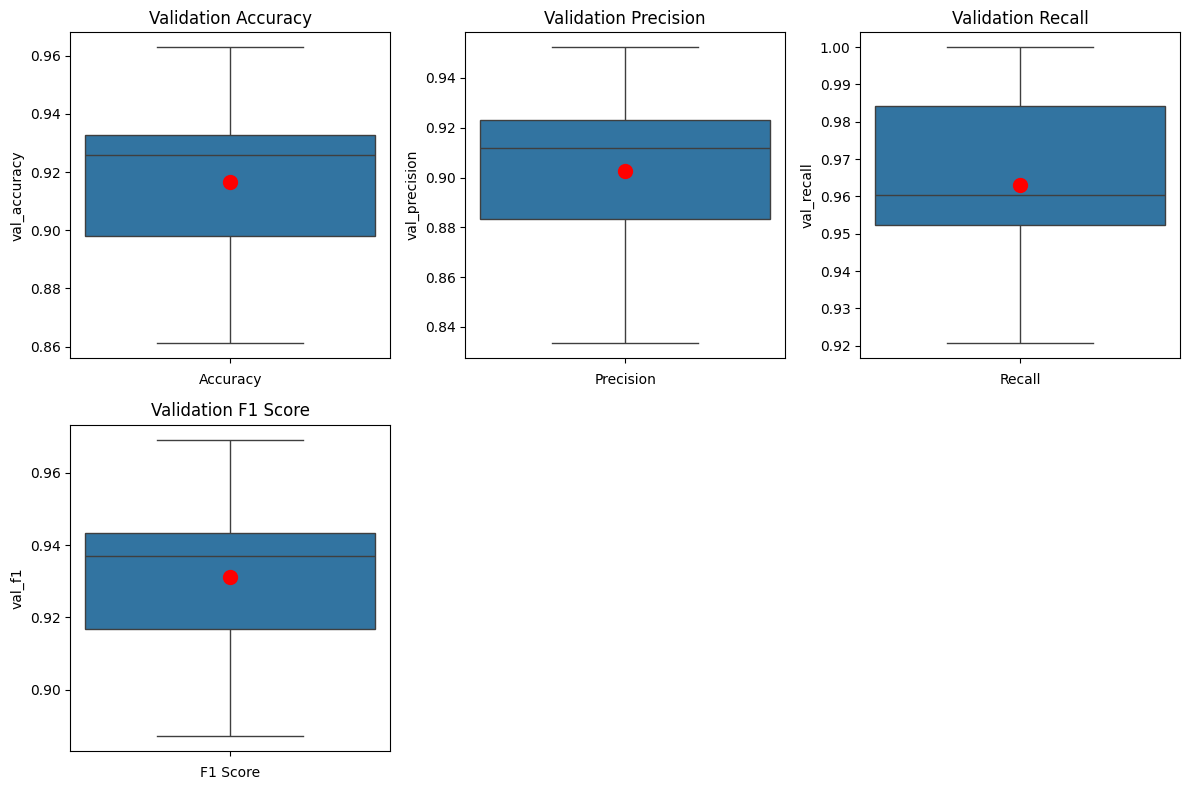

In [14]:
# Convert the metrics to a DataFrame for easier plotting
metrics_df = pd.DataFrame(all_metrics, columns=['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_f1'])

# Plot the box plots for each metric
plt.figure(figsize=(12, 8))

# Box plot for validation accuracy
plt.subplot(2, 3, 1)
sns.boxplot(y=metrics_df['val_accuracy'])
plt.title('Validation Accuracy')
plt.xlabel('Accuracy')
mean_val = metrics_df['val_accuracy'].mean()
plt.scatter(0, mean_val, color='red', s=100, zorder=10)

# Box plot for validation precision
plt.subplot(2, 3, 2)
sns.boxplot(y=metrics_df['val_precision'])
plt.title('Validation Precision')
plt.xlabel('Precision')
mean_val = metrics_df['val_precision'].mean()
plt.scatter(0, mean_val, color='red', s=100, zorder=10)

# Box plot for validation recall
plt.subplot(2, 3, 3)
sns.boxplot(y=metrics_df['val_recall'])
plt.title('Validation Recall')
plt.xlabel('Recall')
mean_val = metrics_df['val_recall'].mean()
plt.scatter(0, mean_val, color='red', s=100, zorder=10)

# Box plot for validation F1 score
plt.subplot(2, 3, 4)
sns.boxplot(y=metrics_df['val_f1'])
plt.title('Validation F1 Score')
plt.xlabel('F1 Score')
mean_val = metrics_df['val_f1'].mean()
plt.scatter(0, mean_val, color='red', s=100, zorder=10)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [15]:
# Save the metrics for later comparison
metrics_df.to_csv("fedMetrics/MLP_metrics.csv", index=False)

print("Finished Cross-Validation")

Finished Cross-Validation
